In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.optim as optim

In [35]:
def loadImgs(input_dir='./data/extra/images'):
    re_path = os.path.join(input_dir, '*.jpg')
    data_len = glob(re_path).__len__()

    x = tuple()
    for idx in range(data_len):
        img = plt.imread(os.path.join(input_dir, str(idx)+'.jpg'))
        img = np.expand_dims(img, axis=0) # shape(1, 64, 64, 3)
        x += (img,)
        
        
    x = np.concatenate(x, axis=0) # shape(num, 64, 64, 3)
    x = x.transpose(0,3,1,2)
    
    x = x/255
    print('Finish input data loading, shape : ', x.shape)
    return x

def loadTags(input_path='data/extra/tags.csv', hair_list=None, eye_list=None, len_=100000):
    if hair_list is None:
        hair_list = ['orange','white','aqua','gray','green','red','purple','pink','blue','black','brown','blonde']
    if eye_list is None:
        eye_list = ['orange','yellow','aqua','green','red','purple','pink','blue','black','brown']
    
    csv = pd.read_csv(input_path, header=None)
    tag_list = csv.iloc[:,1].values
    
    y = []
    
    for idx, tag in enumerate(tag_list):
        hair_c = tag.split(' ')[0]
        eye_c = tag.split(' ')[2]
        y.append([hair_list.index(hair_c), eye_list.index(eye_c)])
        
            
#     y = np.expand_dims(np.array(y), axis=1)
    
    print('Finish input tag loading, len : ', y.__len__())
    return y


In [36]:
x = loadImgs(input_dir='./data/extra/images')
y = loadTags()

Finish input data loading, shape :  (36740, 3, 64, 64)
Finish input tag loading, len :  36740


In [40]:
pd.read_csv('data///extra/tags.csv')

,0,aqua hair aqua eyes
0,1,aqua hair aqua eyes
1,2,aqua hair aqua eyes
2,3,aqua hair aqua eyes
3,4,aqua hair aqua eyes
4,5,aqua hair aqua eyes
5,6,aqua hair aqua eyes
6,7,aqua hair aqua eyes
7,8,aqua hair aqua eyes
8,9,aqua hair aqua eyes
9,10,aqua hair aqua eyes


In [37]:
batch_size = 32

dataset = Data.TensorDataset(torch.FloatTensor(x), torch.LongTensor(y))
dataloader = Data.DataLoader(
            dataset = dataset,
            batch_size = batch_size,
            shuffle = True,
        )

In [38]:
class generator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, noise_dim=64, tag_dim=22, embed_dim=64):
        super(generator, self).__init__()
        
        self.embed = nn.Linear(tag_dim, embed_dim)
        
        self.fc = nn.Sequential(
#             nn.Linear(noise_dim+embed_dim, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Linear(1024, 16 * 16 * 16),

            nn.Linear(noise_dim+embed_dim, 16*16*16),
            nn.BatchNorm1d(16 * 16 * 16),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1,
                                output_padding=1, bias=False), # (b, 32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1,
                                padding=1, bias=False), # (b, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1,
                                output_padding=1, bias=False),# (b, 16, 64, 64)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1,
                                padding=1, bias=False), # (b, 3, 64, 64)
            nn.Tanh(),
        )

    def forward(self, input, label):
        label = self.embed(label)
        
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, 16, 16, 16)
        x = self.deconv(x)
        return x

class discriminator(nn.Module):
    def __init__(self, noise_dim=64, tag_dim=22, embed_dim=64):
        super(discriminator, self).__init__()
    
        self.embed = nn.Linear(tag_dim, embed_dim)
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3,
                        stride=1, padding=1, bias=False), # (b, 16, 64, 64)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=4,
                        stride=2, padding=1, bias=False), # (b, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 32, kernel_size=3,
                        stride=1, padding=1, bias=False), # (b, 32, 32, 32)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, kernel_size=4,
                       stride=2, padding=1, bias=False), # (b, 16, 16, 16)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
        )

        self.fc = nn.Sequential(
#             nn.Linear(16 * 16 * 16, 1024),
#             nn.BatchNorm1d(1024),
#             nn.Linear(1024, noise_dim),
            
            nn.Linear(16 * 16 * 16, noise_dim),
            nn.BatchNorm1d(noise_dim),
            nn.LeakyReLU(0.2),
        )

        # after concatenate img and tag info
        self.out = nn.Sequential(
            nn.Linear(noise_dim + embed_dim, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, input, label):
        label = self.embed(label)
        
        x = self.conv(input)
        x = x.view(-1, 16 * 16 * 16)
        x = self.fc(x)
        x = torch.cat([x,label], 1)
        x = self.out(x)
        return x

    
class cDCGAN:
    def __init__(self, noise_dim=64,
                 embed_dim=64, sample_num=3,
                 hair_list = ['orange','white','aqua','gray','green','red','purple','pink','blue','black','brown','blonde'],
                 eye_list = ['orange','yellow','aqua','green','red','purple','pink','blue','black','brown'],
                ):
        super(cDCGAN, self).__init__()
        
        self.model_name = 'cDCGAN'
        self.path = './model/'
        self.gpu_mode = torch.cuda.is_available()
        
        self.sample_num = sample_num
        self.noise_dim = noise_dim
        self.hair_dim = hair_list.__len__()
        self.eye_dim = eye_list.__len__()
        self.tag_dim = self.hair_dim + self.eye_dim
        
        self.hair_list = hair_list
        self.eye_list = eye_list
        self.sample_z = self.sample_noise(num=sample_num)
        self.sample_y = self.sample_tags(num=sample_num)
        
        self.G = generator(noise_dim=noise_dim, tag_dim=self.tag_dim, embed_dim=embed_dim)
        self.D = discriminator(noise_dim=noise_dim, tag_dim=self.tag_dim, embed_dim=embed_dim)
        
        self.BCE_loss = nn.BCELoss()

        self.G_optimizer = optim.Adam(self.G.parameters(), lr=2e-3, betas=(0.5, 0.999))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=2e-3, betas=(0.5, 0.999))
    
        if self.gpu_mode:
            self.G = self.G.cuda()
            self.D = self.D.cuda()
            self.BCE_loss = self.BCELoss.cuda()
            
        print('---------- Networks architecture -------------')
        self.print_network(self.G)
        self.print_network(self.D)
        print('-----------------------------------------------')
        
    def forward(self, input, label):
        x = self.G(input, label)
        out = self.D(x, label)
        return out
    
    def train(self, dataloader, n_epoch=300, D_time=1, G_time=1):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []
        
        batch_size = dataloader.batch_size
        
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = Variable(torch.ones(batch_size, 1).cuda()), Variable(torch.zeros(batch_size, 1).cuda())
        else:
            self.y_real_, self.y_fake_ = Variable(torch.ones(batch_size, 1)), Variable(torch.zeros(batch_size, 1))
        
        print('training start!!')
        self.D.train()
        start_time = time.time()
        for epoch in range(n_epoch):
            self.G.train()
            epoch_start_time = time.time()
            for itr, (x_, y_) in enumerate(dataloader):
                if itr == dataloader.dataset.__len__() // batch_size:
                    break
                z_ = self.sample_noise(num=batch_size)
                y_head_ = self.sample_tags(num=batch_size)
                y_ = self.tag_preprocess(y_)

                if self.gpu_mode:
                    x_ = Variable(x_, requires_grad=True).cuda()
                else:
                    x_ = Variable(x_, requires_grad=True)
                    
#                 print('x_.shape', x_.shape) # (batch, 3, 64, 64)
#                 print('y_.shape', y_.shape) # (batch)
#                 print('z_.shape', z_.shape) # (batch, 64)
#                 print('y_head_.shape', y_head_.shape) # (batch)
                
                # update D network
                mean_D_loss = 0
                for _ in range(D_time):
                    self.D_optimizer.zero_grad()
                    # real
                    D_real = self.D(x_, y_)
                    D_real_loss = self.BCE_loss(D_real, self.y_real_)
                    # fake tag
                    D_fake_tag = self.D(x_, y_head_)
                    D_fake_tag_loss = self.BCE_loss(D_fake_tag, self.y_fake_)
                    # fake img
                    G_ = self.G(z_, y_)
                    D_fake_img = self.D(G_, y_)
                    D_fake_img_loss = self.BCE_loss(D_fake_img, self.y_fake_)
                    
                    D_loss = D_real_loss + ((D_fake_tag_loss + D_fake_img_loss) / 2)
                    mean_D_loss += D_loss.data[0]

                    D_loss.backward()
                    self.D_optimizer.step()
                if D_time is not 0:
                    mean_D_loss /= D_time
                self.train_hist['D_loss'].append(float(mean_D_loss))
                
                # update G network
                mean_G_loss = 0
                for _ in range(G_time):
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_, y_)
                    D_fake = self.D(G_, y_)
                    G_loss = self.BCE_loss(D_fake, self.y_real_)
                    
                    mean_G_loss += G_loss.data[0]
                    
                    G_loss.backward()
                    self.G_optimizer.step()
                if G_time is not 0:
                    mean_G_loss /= G_time
                self.train_hist['G_loss'].append(float(mean_G_loss))

                
            print("Epoch: [%2d], cost: %d sec | D_loss: %.8f, G_loss: %.8f" %
                  ((epoch + 1),(time.time() - epoch_start_time), D_loss.data[0], G_loss.data[0]))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            self.visualize_results(num=self.sample_num)
            
        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              n_epoch, self.train_hist['total_time'][0]))
        print("Training finish !!!")
    
    def tag_preprocess(self, input): # input from dataloader
        # input shape (batch, 2=(hair_idx, eye_idx))
        num = input.shape[0] # bthc_size
        hair_tags = input[:,0]
        eye_tags = input[:,1]
#         print(hair_tags)
        
        hair_ary = np.zeros((num, self.hair_dim))
        eye_ary = np.zeros((num, self.eye_dim))
        
        hair_ary[np.arange(num), hair_tags] = 1
        eye_ary[np.arange(num), eye_tags] = 1
        
        y_ = np.concatenate((hair_ary, eye_ary), axis=1)
        
        if self.gpu_mode:
            y_ = Variable(torch.FloatTensor(y_), requires_grad=True).cuda()
        else:
            y_ = Variable(torch.FloatTensor(y_), requires_grad=True)
        return y_
    
    def sample_noise(self, num=3):
#         sample_z = np.random.normal(self.mu, self.sigma, num*self.z_dim).reshape(num, self.z_dim)
        sample_z = np.random.rand(num, self.noise_dim)
    
        if self.gpu_mode:
            sample_z = Variable(torch.FloatTensor(sample_z), requires_grad=True).cuda()
        else:
            sample_z = Variable(torch.FloatTensor(sample_z), requires_grad=True)
        return sample_z
    
    def sample_tags(self, num=3):
        hair_tags = np.random.randint(self.hair_dim, size=num)
        eye_tags = np.random.randint(self.eye_dim, size=num)
        
        
        
        hair_ary = np.zeros((num, self.hair_dim))
        eye_ary = np.zeros((num, self.eye_dim))
        
        hair_ary[np.arange(num), hair_tags] = 1
        eye_ary[np.arange(num), eye_tags] = 1
        
        sample_y = np.concatenate((hair_ary, eye_ary), axis=1)
        
        if self.gpu_mode:
            sample_y = Variable(torch.FloatTensor(sample_y), requires_grad=True).cuda()
        else:
            sample_y = Variable(torch.FloatTensor(sample_y), requires_grad=True)
        
        return sample_y, sample_y_label
    
    
    def visualize_results(self, fix=True, num=3):
        self.G.eval()

#         if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
#             os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

#         tot_num_samples = min(self.sample_num, self.batch_size)
#         image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            samples = self.G(self.sample_z, self.sample_y)
        else:
            sample_z = self.sample_noise(num=num)
            sample_y = self.sample_tags(num=num)
            samples = self.G(sample_z, sample_y)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)
        
        fig=plt.figure()
        for idx, sample in enumerate(samples):
            fig.add_subplot(1,num,(idx+1)) # (row, column, idx)
            
#             max_n = max(sample.max(),1)
#             min_n = min(sample.min(),0)
#             plt.imshow((sample-min_n)/(max_n-min_n))
            plt.imshow(sample)
        plt.show()
    
    def print_network(self, net):
        num_params = 0
        for param in net.parameters():
            num_params += param.numel()
        print(net)
        print('Total number of parameters: %d' % num_params)
    
    def save(self, path=None, class_=''):
        if path is None:
            path = self.path
        
        if not os.path.exists(path):
            os.makedirs(path)

        torch.save(self.G.state_dict(), os.path.join(path, self.model_name + class_ + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(path, self.model_name + class_ + '_D.pkl'))

        with open(os.path.join(path, self.model_name + class_ + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)
            
cdcgan = cDCGAN()

---------- Networks architecture -------------
generator(
  (embed): Linear(in_features=22, out_features=64, bias=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU()
    (6): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU()
    (9): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

training start!!
Epoch: [ 1], cost: 3793 sec | D_loss: 1.38107693, G_loss: 0.83759677


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


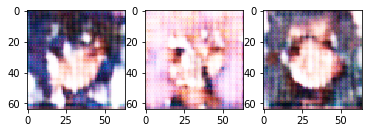

KeyboardInterrupt: 

In [39]:
cdcgan.train(dataloader=dataloader, n_epoch=100)